## Capstone Project Battle of the Neighbourhoods - Week4

#### Problem
Description: If an international investor wants to open a business, and has a choice of 3 Cities, New York, Toronto and Cape Town. Which of these cities will be a good investment. If we take into consideration GDP per capita, labour costs and market saturation. How much competition is there, and how much will people be willing to spend on a specific product. How does the taxes compare for the 3 different countries? All these are questions an investor might have. The business that the investor is setting up is a tech startup whose primary focus is App and Web development for Night Clubs. Intially he will only have about 10 employees that will telecomute, he wants to give the employees a good living standard, but also wants to turn a profit within a year. 


### Data description
I will be looking at Financial Data for the 3 countries in which these 3 cities are located. I will also be looking at cost of living for all 3 cities this data will be obtained from www.tradingeconomics.com and www.expatistan.com respectively. I will use the foursquare API to map the locations of the top 10 night clubs in these cities and check if there are any techstartups in their vicinity that might give competition. The working folder for the poject on github is https://github.com/pieterdt1979/coursera_capstone/tree/master/Capstone-Week4-5 this is still a work in progress and will later be used in my final report.

In [60]:
## Importing all the modules that will be needed
# !pip3 install tradingeconomics
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')
import tradingeconomics as te # This will be used to pull economic data for the two countries
from requests import get  # To scrape cost of living as well from:
from bs4 import BeautifulSoup   # https://www.expatistan.com/cost-of-living/toronto?currency=USD
                                # https://www.expatistan.com/cost-of-living/cape-town?currency=USD
                                # https://www.expatistan.com/cost-of-living/new-york
import tradingeconomics as te
import folium
from sklearn.cluster import KMeans
import json
from datetime import datetime
import time
import csv
import sys

In [13]:
#First I will get the data from tradingeconomics

def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]


        
countries = ['United States', 'Canada', 'South Africa'] #Choose your Countries
indicators = ['GDP'] #Choose your indicators. WARNING: It must be written like on https://api.tradingeconomics.com/indicators.
today_date = datetime.now().strftime("%Y-%m-%d")
te.login('guest:guest') #Insert your API Key
for indicator in indicators:
        csv_file_name = indicator + "_" + today_date+".csv"
        pfa = pd.DataFrame()
        print("----------------")
        print(indicator)
        for countries_chunk in chunks(countries, 3): 
            print(countries_chunk)
            mydata = te.getHistoricalData(country = countries_chunk, indicator = [indicator],  initDate = '1950-01-01', endDate = today_date  ) #Choose initDate or EndDate
            for country in countries_chunk:
                for a in mydata[country][indicator][0]:
                    dfa = a.to_frame()
                    pfa = pd.concat([pfa, dfa],axis=1) #axis=1, concatenation on the columns.
            time.sleep(1)
        pfa.to_csv('financial_data.csv', header=countries)

----------------
GDP
['United States', 'Canada', 'South Africa']


In [22]:
#Load the gdp data from file
gdp_data = pd.read_csv('financial_data.csv')
gdp_data.rename(columns={'Unnamed: 0':'Date'}, inplace=True)
us_mean = gdp_data['United States'].mean()
za_mean = gdp_data['South Africa'].mean()
gdp_data['United States'].replace(np.nan, us_mean, inplace=True)
gdp_data['South Africa'].replace(np.nan, za_mean, inplace=True)
gdp_data

,Date,United States,Canada,South Africa
0,2015-12-31,19562.226667,1552.9,336.973333
1,2016-12-31,18707.190000,1526.7,295.750000
2,2017-12-31,19485.390000,1646.9,348.870000
3,2018-12-31,20494.100000,1709.3,366.300000


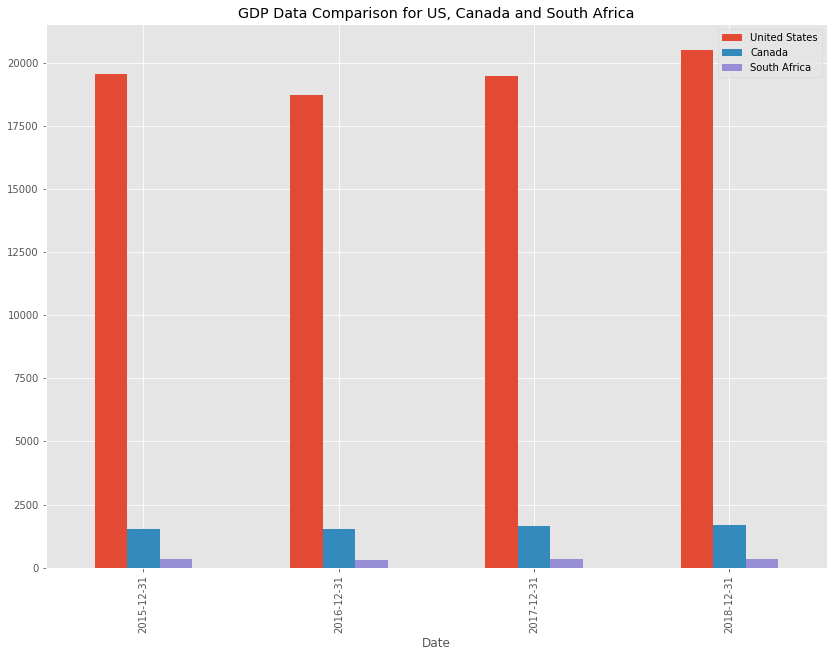

In [278]:
gdp_data.set_index(gdp_data['Date'], inplace=True)
gdp_data.plot(kind='bar', figsize=(14,10))
plt.title('GDP Data Comparison for US, Canada and South Africa')
plt.savefig('gdp_plot.jpg')

In [161]:
# Now we can get the cost of living for each country
tor_col = pd.read_html('https://www.expatistan.com/cost-of-living/toronto?currency=USD')
cpt_col = pd.read_html('https://www.expatistan.com/cost-of-living/cape-town?currency=USD')
ny_col = pd.read_html('https://www.expatistan.com/cost-of-living/new-york-city')

In [162]:
#Fix the data for the ny as we will be adding the columns for the two other cities to it
ny_col[0].drop('Food', axis=1, inplace=True)
ny_col[0].drop('Unnamed: 3', axis=1, inplace=True)
ny_col[0].rename(columns={'Food.1':'Expense Types', '[Edit]':'New York'}, inplace=True)
ny_col[0].drop([13,25,26,31,36,46], inplace=True)
ny_col[0].reset_index(drop=True, inplace=True)
ny_col[0].shape

(52, 2)

In [163]:
tor_col[0].drop([0,14,15,27,28,29,34,35,40,41,51,52], inplace=True)
tor_col[0].reset_index(drop=True, inplace=True)
tor_col[0].shape

(52, 4)

In [164]:
cpt_col[0].drop([0,14,15,27,28,29,34,35,40,41,51,52], inplace=True)
cpt_col[0].reset_index(drop=True, inplace=True)
cpt_col[0].shape

(52, 4)

In [170]:
ny_col[0]['Canada'] = tor_col[0][tor_col[0].columns[3]]

In [171]:
ny_col[0]['Cape Town'] = cpt_col[0][cpt_col[0].columns[3]]

In [228]:
combined = pd.DataFrame(ny_col[0])
print('Data Types: ',combined.dtypes)
combined.head(5)

Data Types:  Expense Types    object
New York         object
Canada           object
Cape Town        object
dtype: object


,Expense Types,New York,Canada,Cape Town
0,Basic lunchtime menu (including a drink) in th...,$17,($13),($8)
1,Combo meal in fast food restaurant (Big Mac Me...,$9,($8),($4.03)
2,500 gr (1 lb.) of boneless chicken breast,$6,($5.74),($3.08)
3,1 liter (1 qt.) of whole fat milk,$1.12,($2.16),($0.85)
4,"12 eggs, large",$4.67,($2.88),($2.18)


In [234]:
# The data needs to be cleaned some moreso that the dollar values for each country is displayed as floats
# df[["bore", "stroke"]] = df[["bore", "stroke"]].astype("float")
combined[['New York', 'Canada', 'Cape Town']]=combined[['New York', 'Canada', 'Cape Town']].replace(to_replace=r'\$',
                                                                                                    value='', regex=True)
combined[['New York', 'Canada', 'Cape Town']]=combined[['New York', 'Canada', 'Cape Town']].replace(to_replace=r'\(',
                                                                                                    value='', regex=True)
combined[['New York', 'Canada', 'Cape Town']]=combined[['New York', 'Canada', 'Cape Town']].replace(to_replace=r'\)',
                                                                                                    value='', regex=True)
combined[['New York', 'Canada', 'Cape Town']]=combined[['New York', 'Canada', 'Cape Town']].replace(to_replace=r'\,',
                                                                                                    value='', regex=True)

In [236]:
combined[['New York', 'Canada', 'Cape Town']] = combined[['New York', 'Canada', 'Cape Town']].astype("float")
print(combined.dtypes) # Peeking the data types again
combined.head(5) # Just checking that nothing was lost in the conversion

Expense Types     object
New York         float64
Canada           float64
Cape Town        float64
dtype: object


,Expense Types,New York,Canada,Cape Town
0,Basic lunchtime menu (including a drink) in th...,17.00,13.00,8.00
1,Combo meal in fast food restaurant (Big Mac Me...,9.00,8.00,4.03
2,500 gr (1 lb.) of boneless chicken breast,6.00,5.74,3.08
3,1 liter (1 qt.) of whole fat milk,1.12,2.16,0.85
4,"12 eggs, large",4.67,2.88,2.18


In [238]:
combined.set_index('Expense Types', inplace=True) # Change the index

KeyError: "None of ['Expense Types'] are in the columns"

In [275]:
combined[32:41]

,New York,Canada,Cape Town
Expense Types,,,
"Cold medicine for 6 days (Tylenol, Frenadol, Coldrex, or equivalent brands)",9.00,9.00,4.35
1 box of antibiotics (12 doses),27.00,21.00,10.00
Short visit to private Doctor (15 minutes),142.00,73.00,29.00
"1 box of 32 tampons (Tampax, OB, ...)",8.00,5.24,2.96
"Deodorant, roll-on (50ml ~ 1.5 oz.)",4.70,3.64,2.05
Hair shampoo 2-in-1 (400 ml ~ 12 oz.),6.00,3.64,3.65
4 rolls of toilet paper,4.12,2.00,1.52
Tube of toothpaste,1.98,1.88,1.36
Standard men's haircut in expat area of the city,28.00,19.00,9.00


In [276]:
# Splitting it for the different categories
food_comp = combined[0:13]
housing_comp = combined[13:24]
clothing_comp = combined[24:28]
transport_comp = combined[28:32]
care_comp = combined[32:41]
entertain_comp = combined[41:]

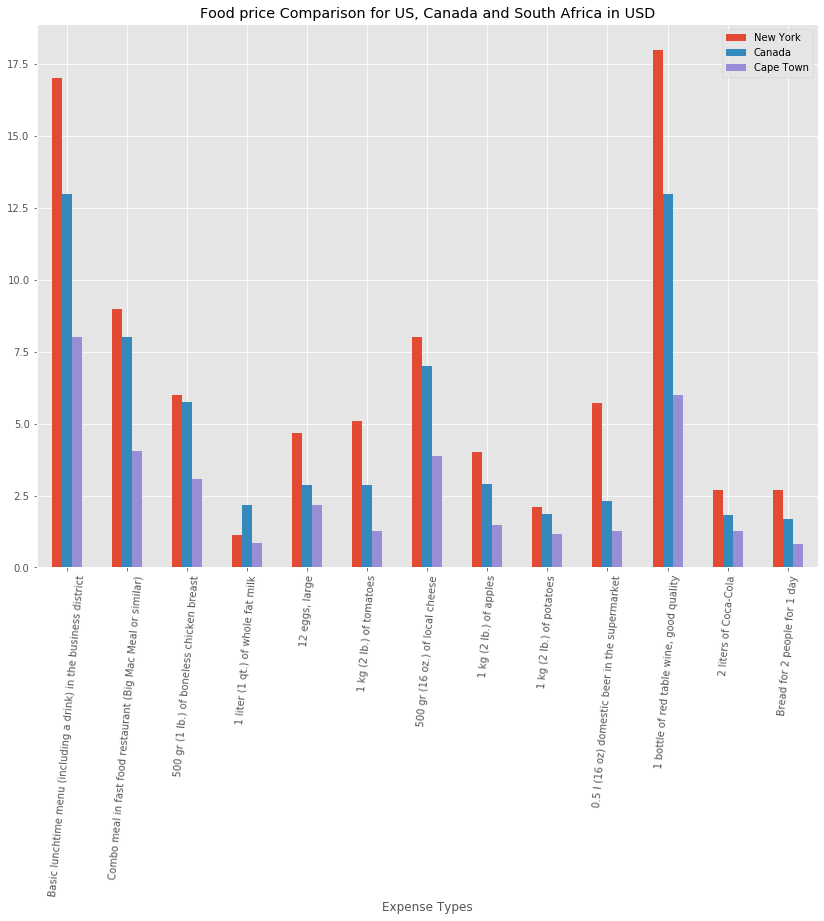

In [297]:
food_comp.plot(kind='bar', figsize=(14,10), rot=85)
plt.title('Food price Comparison for US, Canada and South Africa in USD')
plt.savefig('food_comp.jpg')

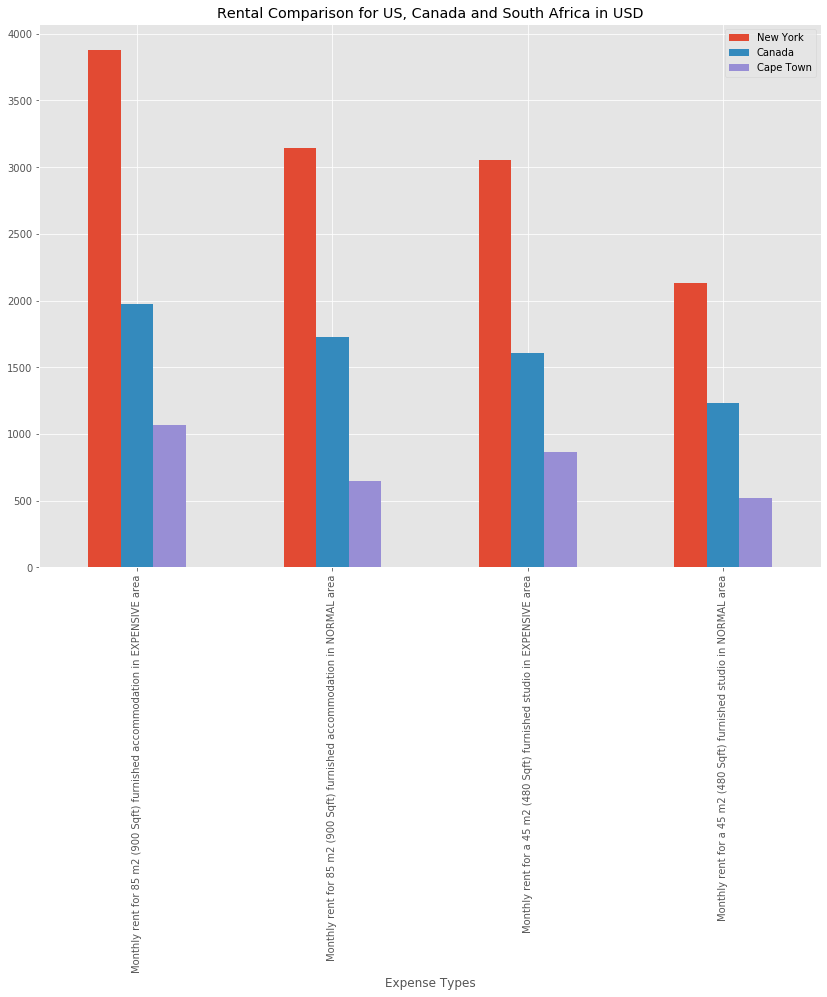

In [326]:
pd.DataFrame(housing_comp[0:2].append(housing_comp[3:5])).plot(kind='bar', figsize=(14,10))
plt.title('Rental Comparison for US, Canada and South Africa in USD')
plt.savefig('rental_comp.jpg')

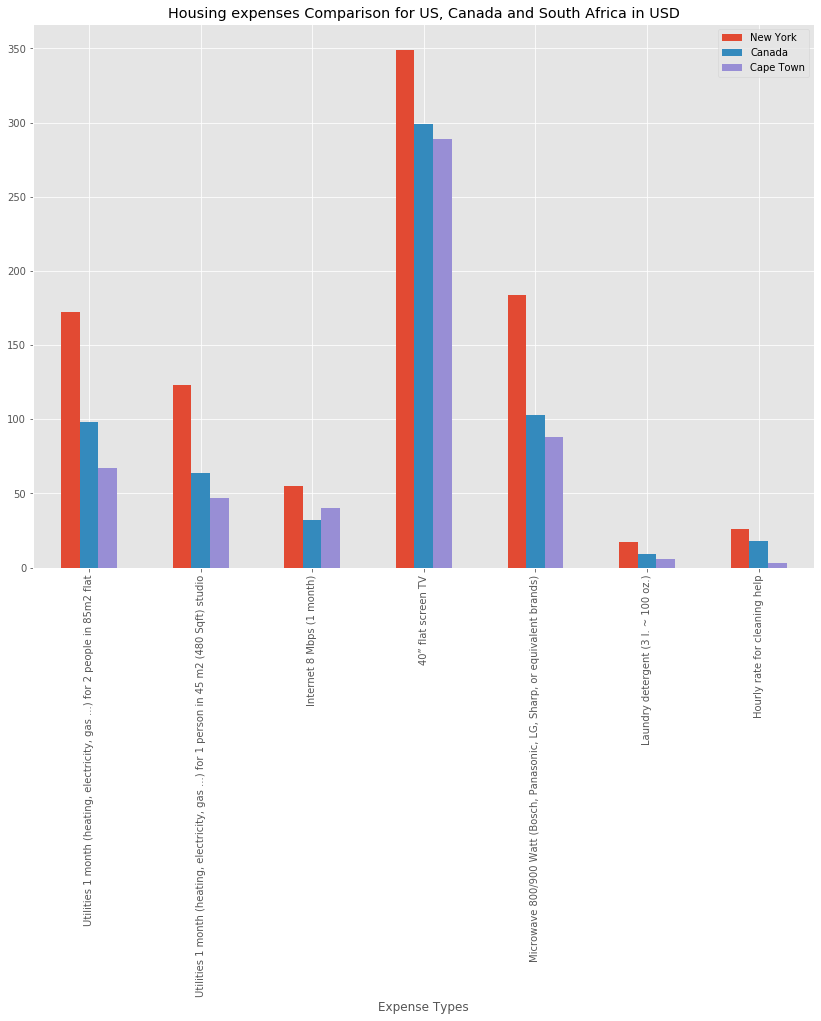

In [330]:
pd.DataFrame(housing_comp[2:3].append(housing_comp[5:])).plot(kind='bar', figsize=(14,10))
plt.title('Housing expenses Comparison for US, Canada and South Africa in USD')
plt.savefig('house_hold.jpg')

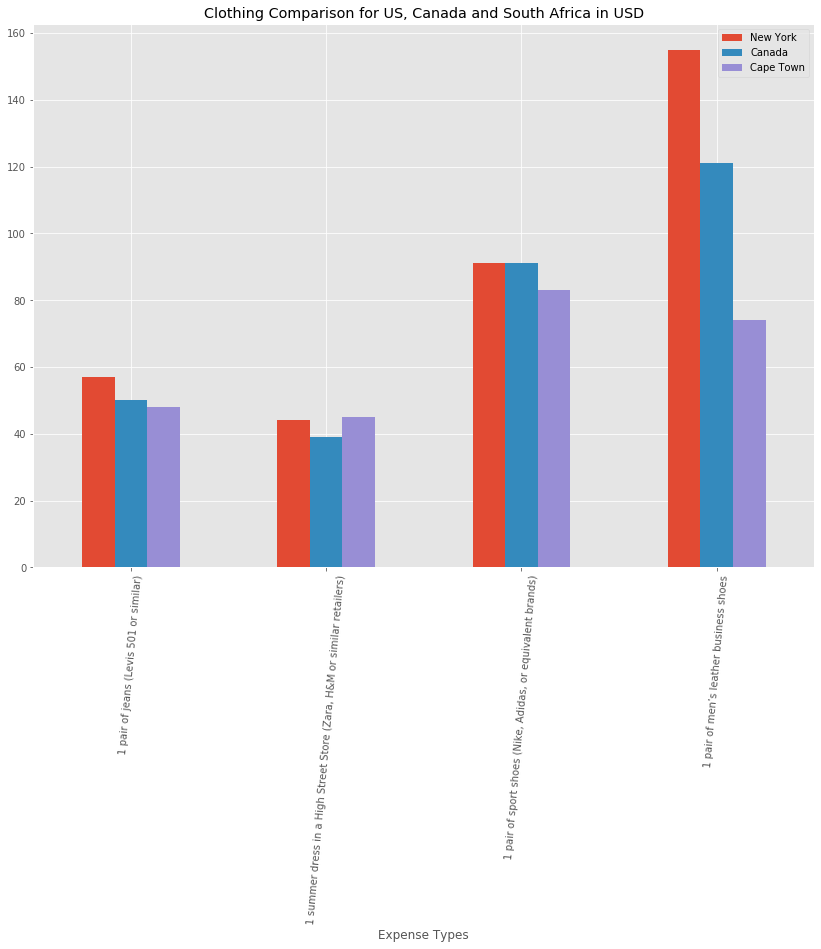

In [331]:
clothing_comp.plot(kind='bar', figsize=(14,10), rot=85)
plt.title('Clothing Comparison for US, Canada and South Africa in USD')
plt.savefig('clothing_comp.jpg')

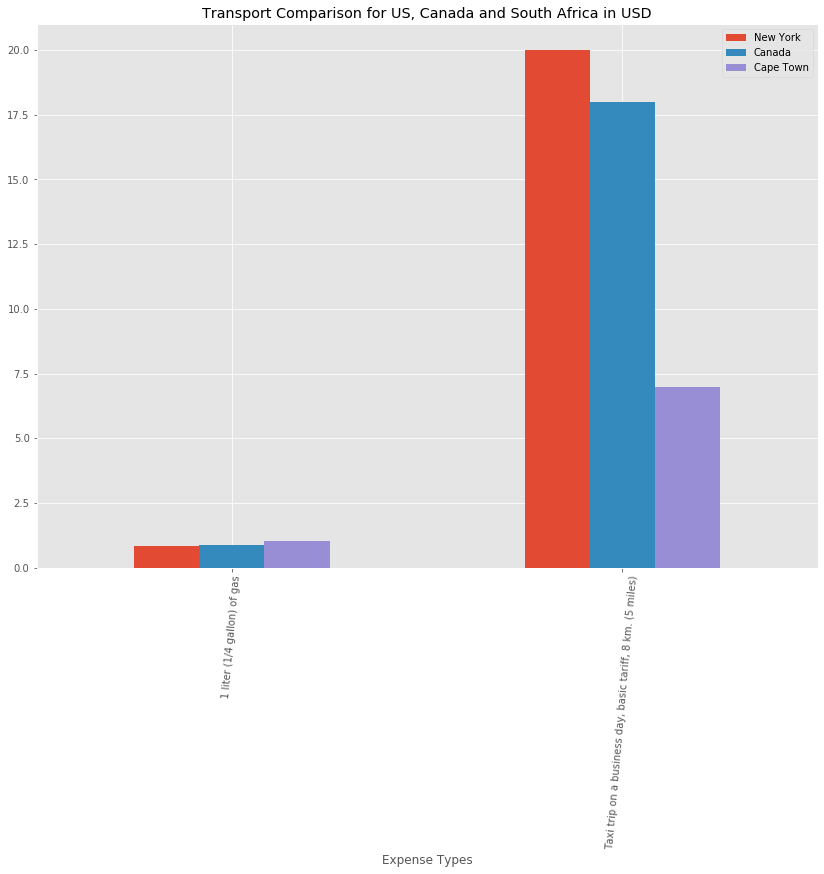

In [332]:
transport_comp[1::2].plot(kind='bar', figsize=(14,10), rot=85)
plt.title('Transport Comparison for US, Canada and South Africa in USD')
plt.savefig('transport_comp_1.jpg') # Interesting Fuel in South-Africa is more expensive, but the taxi trip are cheaper

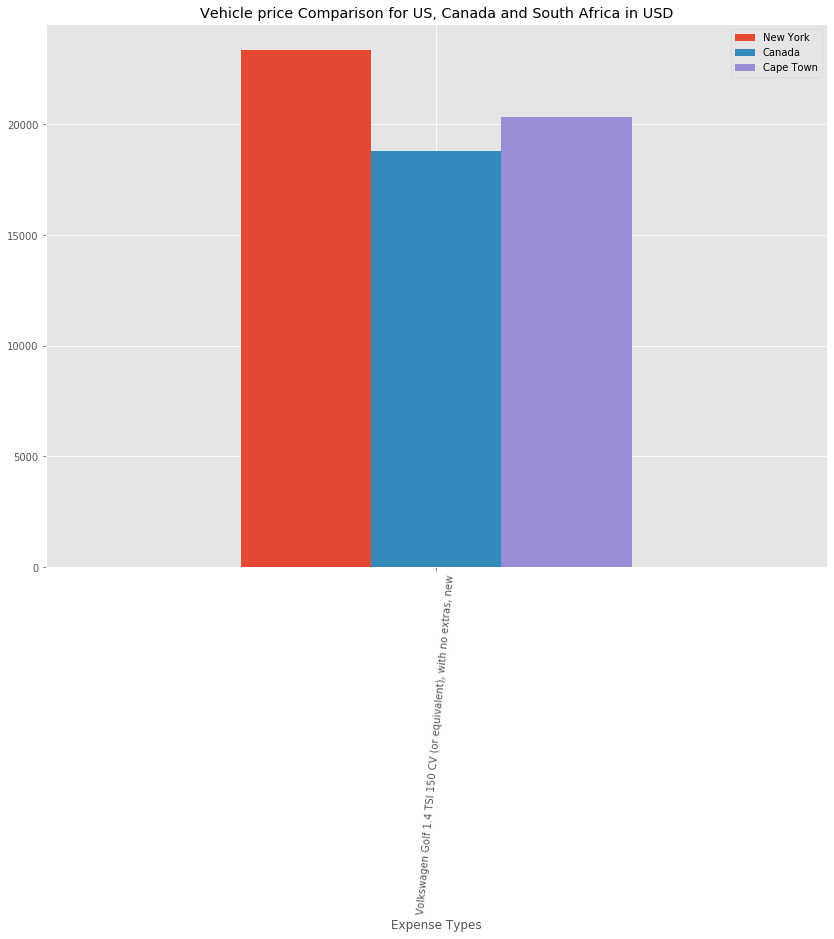

In [333]:
transport_comp[0:1].plot(kind='bar', figsize=(14,10), rot=85)
plt.title('Vehicle price Comparison for US, Canada and South Africa in USD')
plt.savefig('transport_comp_2.jpg') 

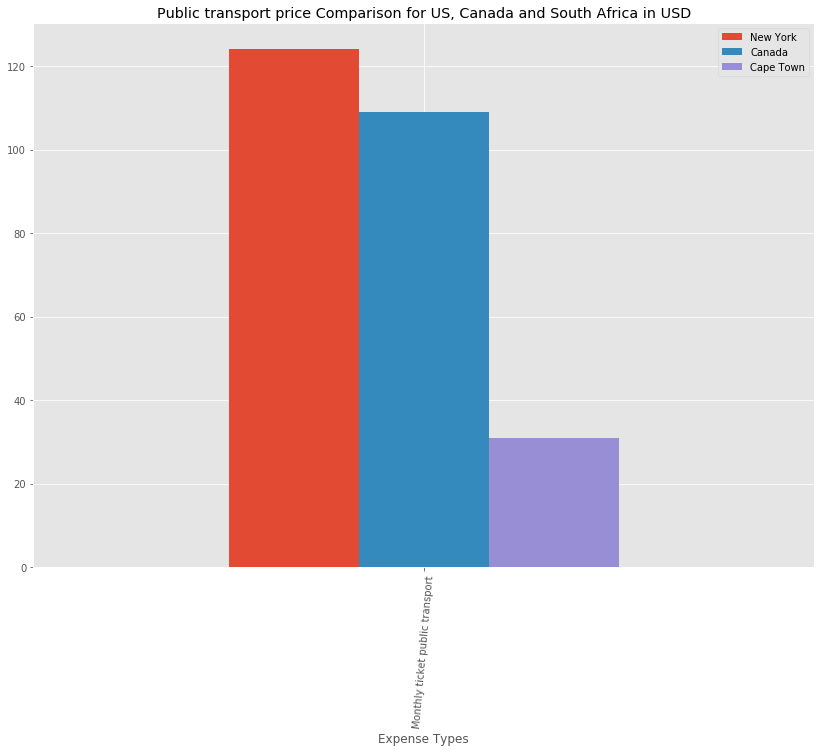

In [336]:
transport_comp[2:3].plot(kind='bar', figsize=(14,10), rot=85)
plt.title('Public transport price Comparison for US, Canada and South Africa in USD')
plt.savefig('transport_comp_3.jpg') # Still wondering about the fuel that is more expensive, yet public transport is also cheaper

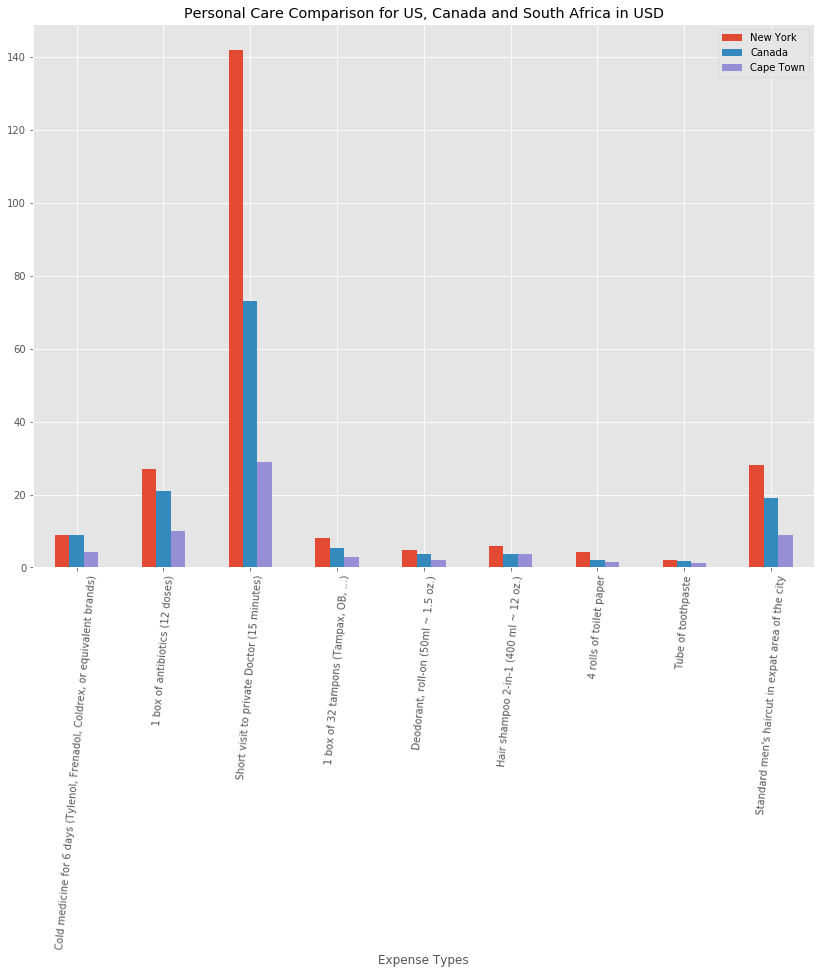

In [337]:
care_comp.plot(kind='bar', figsize=(14,10), rot=85)
plt.title('Personal Care Comparison for US, Canada and South Africa in USD')
plt.savefig('personal_care_comp.jpg') 

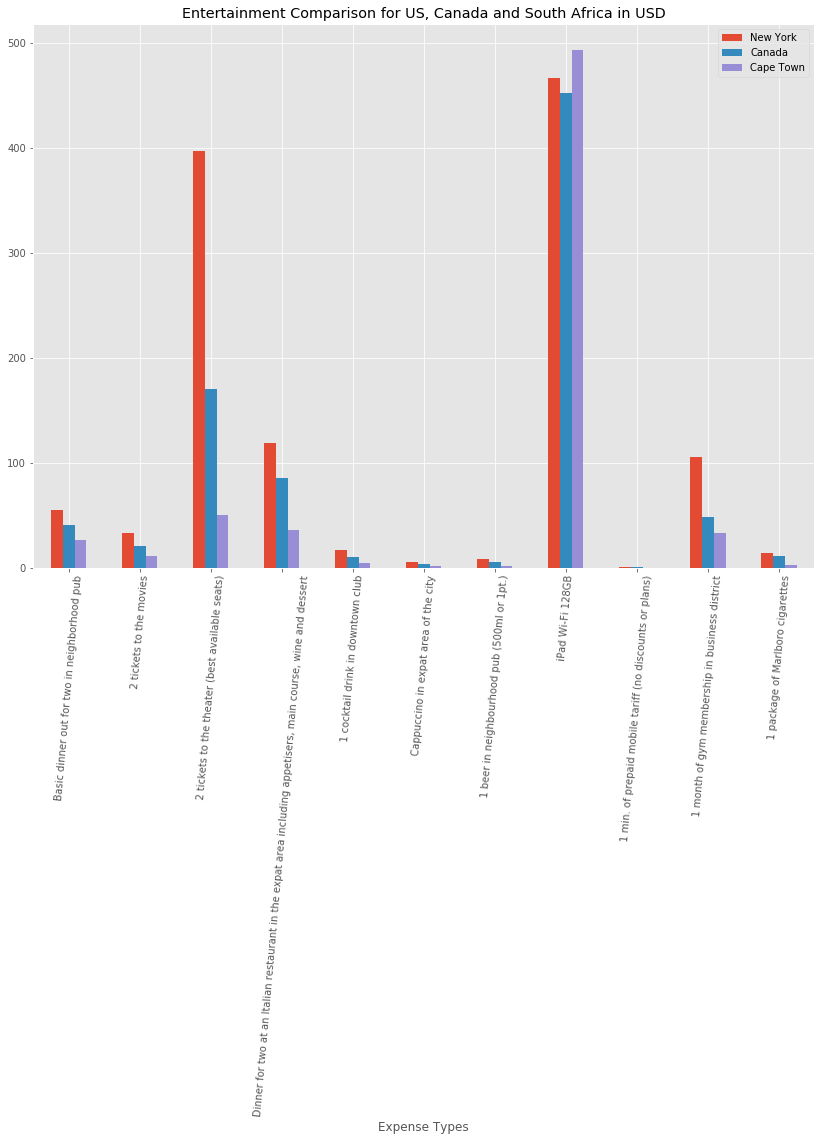

In [338]:
entertain_comp.plot(kind='bar', figsize=(14,10), rot=85)
plt.title('Entertainment Comparison for US, Canada and South Africa in USD')
plt.savefig('entertainment.jpg')

In [353]:
#Function to get the nearby venues
def getNearbyVenues(names, latitudes, longitudes, radius=5000, categoryids=[]):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        if len(categoryids) > 0:
            url = url + '&categoryId={}'.format(','.join(categoryids))
            
        # make the GET request
        results = get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        try:    
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except:
            pass
    try:
        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Address', 
              'Neighbourhood Latitude', 
              'Neighbourhood Longitude', 
              'Venue', 
              'Venue Latitude', 
              'Venue Longitude', 
              'Venue Category']
    except:
        nearby_venues = pd.DataFrame(columns=['Address', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category'])

    
    return(nearby_venues)

In [357]:
CLIENT_ID = 'LH2OJQC5DUE5Y3TQZVD3DXDH2A3ASD5MANEVAKEMGDJN0HWT' # your Foursquare ID
CLIENT_SECRET = 'YRM0HCKVDAG5GJU1JYCKPMUWJD0IZUVF1N0ZY3GRKLC3MXT3' # your Foursquare Secret
VERSION = '20191005' # Foursquare API version
LIMIT = 500

In [354]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values (OpenStreetMaps)

def get_geo(address):
    address = address
    geolocator = Nominatim(user_agent="my-application")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return address, latitude, longitude


In [360]:
#So let us start exploring the cities
cities = ['New York, NY', 'Toronto, CA', 'Cape Town, ZA']
latitudes = []
longitudes = []
for c in cities:
    print(c)
    address, lat, long = get_geo(c)
    latitudes.append(lat)
    longitudes.append(long)
nightclubs = '4bf58dd8d48988d11f941735' # 4Square nightclubs category id
tech_startup = '4bf58dd8d48988d125941735' # 4Square tech startups
nearby_venues = getNearbyVenues(cities, latitudes=latitudes, longitudes=longitudes, 
                                radius=20000, categoryids=[nightclubs, tech_startup])
nearby_venues

New York, NY
Toronto, CA
Cape Town, ZA
New York, NY
Toronto, CA
Cape Town, ZA


,Address,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"New York, NY",40.712728,-74.006015,Lavo,40.762657,-73.971688,Nightclub
1,"New York, NY",40.712728,-74.006015,Le Bain,40.740842,-74.008545,Nightclub
2,"New York, NY",40.712728,-74.006015,Paul's Cocktail Lounge,40.719563,-74.005035,Nightclub
3,"New York, NY",40.712728,-74.006015,Electric Room,40.742132,-74.003616,Nightclub
4,"New York, NY",40.712728,-74.006015,Yext,40.740663,-73.986246,Tech Startup
5,"New York, NY",40.712728,-74.006015,Peloton HQ,40.744884,-73.993070,Tech Startup
6,"New York, NY",40.712728,-74.006015,1 OAK,40.743838,-74.006357,Nightclub
7,"New York, NY",40.712728,-74.006015,Up&Down,40.739530,-74.001954,Nightclub
8,"New York, NY",40.712728,-74.006015,The Blond,40.719242,-74.000066,Nightclub
9,"New York, NY",40.712728,-74.006015,The Box,40.721835,-73.992000,Nightclub


In [361]:
nearby_venues['Venue Category'].value_counts()

Nightclub                     120
Tech Startup                   82
Music Venue                     7
Bar                             6
Office                          4
Pub                             2
Speakeasy                       2
Lounge                          2
Steakhouse                      2
Hotel                           1
Gay Bar                         1
Asian Restaurant                1
Advertising Agency              1
Financial or Legal Service      1
Theater                         1
Rock Club                       1
Dive Bar                        1
Coworking Space                 1
Coffee Shop                     1
Restaurant                      1
Name: Venue Category, dtype: int64

From the above we see that there is overall 120 Nightclubs in the 3 Cities and there is 82 Tech Startups

In [396]:
# Analyzing each city
# one hot encoding
venues_onehot = pd.get_dummies(nearby_venues[['Venue Category']], prefix="", prefix_sep="")
# add Address column back to dataframe
venues_onehot['Address'] = nearby_venues['Address'] 

# move neighborhood column to the first column
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
venues_onehot = venues_onehot[fixed_columns]

venues_onehot.head()


,Address,Advertising Agency,Asian Restaurant,Bar,Coffee Shop,Coworking Space,Dive Bar,Financial or Legal Service,Gay Bar,Hotel,...,Music Venue,Nightclub,Office,Pub,Restaurant,Rock Club,Speakeasy,Steakhouse,Tech Startup,Theater
0,"New York, NY",0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,"New York, NY",0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,"New York, NY",0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,"New York, NY",0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,"New York, NY",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [398]:
# Examine the new dataframe
venues_onehot.shape

(238, 21)

In [400]:
#Group the rows by city
cities_grouped = venues_onehot.groupby('Address').mean().reset_index()
cities_grouped

,Address,Advertising Agency,Asian Restaurant,Bar,Coffee Shop,Coworking Space,Dive Bar,Financial or Legal Service,Gay Bar,Hotel,...,Music Venue,Nightclub,Office,Pub,Restaurant,Rock Club,Speakeasy,Steakhouse,Tech Startup,Theater
0,"Cape Town, ZA",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.578947,0.00,0.00,0.00,0.00,0.00,0.026316,0.394737,0.00
1,"New York, NY",0.00,0.01,0.06,0.01,0.00,0.01,0.00,0.00,0.00,...,0.06,0.620000,0.00,0.01,0.01,0.01,0.02,0.010000,0.150000,0.01
2,"Toronto, CA",0.01,0.00,0.00,0.00,0.01,0.00,0.01,0.01,0.01,...,0.01,0.360000,0.04,0.01,0.00,0.00,0.00,0.000000,0.520000,0.00


In [401]:
# Check the new size
cities_grouped.shape

(3, 21)

In [409]:
num_top_venues = 5

for city in cities_grouped['Address']:
    print("----"+city+"----")
    temp = cities_grouped[cities_grouped['Address'] == city].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Cape Town, ZA----
                venue  freq
0           Nightclub  0.58
1        Tech Startup  0.39
2          Steakhouse  0.03
3  Advertising Agency  0.00
4    Asian Restaurant  0.00


----New York, NY----
          venue  freq
0     Nightclub  0.62
1  Tech Startup  0.15
2   Music Venue  0.06
3           Bar  0.06
4     Speakeasy  0.02


----Toronto, CA----
                venue  freq
0        Tech Startup  0.52
1           Nightclub  0.36
2              Office  0.04
3  Advertising Agency  0.01
4               Hotel  0.01




In [410]:
#Function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [421]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Address']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
cities_venues_sorted = pd.DataFrame(columns=columns)
cities_venues_sorted['Address'] = cities_grouped['Address']

for ind in np.arange(cities_grouped.shape[0]):
    cities_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cities_grouped.iloc[ind, :], num_top_venues)

cities_venues_sorted.head()

,Address,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Cape Town, ZA",Nightclub,Tech Startup,Steakhouse,Theater,Gay Bar,Asian Restaurant,Bar,Coffee Shop,Coworking Space,Dive Bar
1,"New York, NY",Nightclub,Tech Startup,Music Venue,Bar,Speakeasy,Theater,Asian Restaurant,Coffee Shop,Dive Bar,Lounge
2,"Toronto, CA",Tech Startup,Nightclub,Office,Lounge,Music Venue,Coworking Space,Financial or Legal Service,Gay Bar,Hotel,Advertising Agency


In [422]:
# Run k-means to cluster the neighbourhoods into 5 clusters
kclusters = 3

cities_grouped_clustering = cities_grouped.drop('Address', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cities_grouped_clustering)
# Check cluster labels generated for each row in the dataframe
kmeans.labels_[0:3]

array([0, 2, 1], dtype=int32)

In [417]:
# add clustering labels
cities_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

venues_merged = nearby_venues
# Merge the data
venues_merged = venues_merged.join(cities_venues_sorted.set_index('Address'), on='Address')

ValueError: cannot insert Cluster Labels, already exists

In [423]:
venues_merged.head()

,Address,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"New York, NY",40.712728,-74.006015,Lavo,40.762657,-73.971688,Nightclub,2,Nightclub,Tech Startup,Music Venue,Bar,Speakeasy,Theater,Asian Restaurant,Coffee Shop,Dive Bar,Lounge
1,"New York, NY",40.712728,-74.006015,Le Bain,40.740842,-74.008545,Nightclub,2,Nightclub,Tech Startup,Music Venue,Bar,Speakeasy,Theater,Asian Restaurant,Coffee Shop,Dive Bar,Lounge
2,"New York, NY",40.712728,-74.006015,Paul's Cocktail Lounge,40.719563,-74.005035,Nightclub,2,Nightclub,Tech Startup,Music Venue,Bar,Speakeasy,Theater,Asian Restaurant,Coffee Shop,Dive Bar,Lounge
3,"New York, NY",40.712728,-74.006015,Electric Room,40.742132,-74.003616,Nightclub,2,Nightclub,Tech Startup,Music Venue,Bar,Speakeasy,Theater,Asian Restaurant,Coffee Shop,Dive Bar,Lounge
4,"New York, NY",40.712728,-74.006015,Yext,40.740663,-73.986246,Tech Startup,2,Nightclub,Tech Startup,Music Venue,Bar,Speakeasy,Theater,Asian Restaurant,Coffee Shop,Dive Bar,Lounge


In [448]:
#Create a map of New York with showing the Nightclubs and Tech startups
ny_map = folium.Map(location=[latitudes[0], longitudes[0]], zoom_start=11)

# add markers to map
ny_venues = nearby_venues.loc[nearby_venues.Address == 'New York, NY']

# add markers to map
for lat, lng, label, category in zip(ny_venues['Venue Latitude'], 
                           ny_venues['Venue Longitude'], ny_venues['Venue'], ny_venues['Venue Category']):
    label = folium.Popup(label, parse_html=True)
    if category == 'Nightclub':    # Where our target clients are
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(ny_map)
    elif category == 'Tech Startup':        #This way we can easily see where the competition might be
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='red',
            fill=True,
            fill_color='#8B0000',
            fill_opacity=0.7,
            parse_html=False).add_to(ny_map)
    
ny_map.save('ny_map.jpg')
ny_map

In [453]:
#Create a map of Toronto showing the Nightclubs and Tech startups
tor_map = folium.Map(location=[latitudes[1], longitudes[1]], zoom_start=11)

# add markers to map
tor_venues = nearby_venues.loc[nearby_venues.Address == 'Toronto, CA']

# add markers to map
for lat, lng, label, category in zip(tor_venues['Venue Latitude'], 
                           tor_venues['Venue Longitude'], tor_venues['Venue'], tor_venues['Venue Category']):
    label = folium.Popup(label, parse_html=True)
    if category == 'Nightclub':    # Where our target clients are
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(tor_map)
    elif category == 'Tech Startup':        #This way we can easily see where the competition might be
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='red',
            fill=True,
            fill_color='#8B0000',
            fill_opacity=0.7,
            parse_html=False).add_to(tor_map)
    
tor_map.save('tor_map.jpg')
tor_map

In [452]:
#Create a map of Toronto showing the Nightclubs and Tech startups
cpt_map = folium.Map(location=[latitudes[2], longitudes[2]], zoom_start=10)

# add markers to map
cpt_venues = nearby_venues.loc[nearby_venues.Address == 'Cape Town, ZA']

# add markers to map
for lat, lng, label, category in zip(cpt_venues['Venue Latitude'], 
                           cpt_venues['Venue Longitude'], cpt_venues['Venue'], cpt_venues['Venue Category']):
    label = folium.Popup(label, parse_html=True)
    if category == 'Nightclub':    # Where our target clients are
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(cpt_map)
    elif category == 'Tech Startup':        #This way we can easily see where the competition might be
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='red',
            fill=True,
            fill_color='#8B0000',
            fill_opacity=0.7,
            parse_html=False).add_to(cpt_map)
    
cpt_map.save('cpt_map.jpg')
cpt_map